In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
modelname = 'Ex02_E2'
exe_name = '/home/harsh/Desktop/modflow_flopy/flopyCourse/mf2005'
model_ws = 'Results/'

mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=model_ws)

In [4]:
nper = 11 #stress period
nstp = [1] + [12]*10 #no of time step
perlen = [1] + [365]*10 #length of stress period
tsmult = [1] + [1.2]*10 #multiplier
steady = [True] + [False]*10 #whether transient or steady-state


zbot = [-50., -100.]
nlay = 3 #2 layers for this example
nrow = 21
ncol = 20

top = np.ones((nrow, ncol), dtype=np.int32)

for i in range(ncol):
    top[:,i] = 396 - i*4

delr = 500
delc = 500

botm = [220,200,0]
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol,
                               delr=delr, delc=delc, top=top, botm=botm,
                              nper = nper, nstp=nstp, perlen=perlen, tsmult=tsmult, steady=steady)

In [5]:
bas = flopy.modflow.ModflowBas(mf, ibound=1, strt=320)

In [7]:
lpf = flopy.modflow.ModflowLpf(mf, hk=[50., 0.01, 200], vka=[10, 0.01, 20], ipakcb=53, laytyp=[1,0,0], ss=1E-5, sy=0.2)
#ss - specific storage; sy - specific yield

In [8]:
rch = flopy.modflow.ModflowRch(mf, rech=0.015) #recharge

In [10]:
#definting stress period data
'''on the first timeperiod (python starts from 0), well pumps 150000,
on the 4th no pumping, and on the 7th it pumps 200000 '''
spd = {1:[[2, 10, 9, -150000]],
      4: [[2, 10, 9, 0]],
      7: [[2, 10, 9, -200000]]
      }

wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd)

In [11]:
#defining river

#this applies a river boundary condition for every row of the last column; rivers water surface head is 320, conductance is 1e5 and river bottom is 318
#0 in spd_riv is for the first period, which is then repeated for every subsequent time period
spd_riv = {0: [[0, i, 19, 320, 1e5, 318] for i in range(nrow)]}


riv = flopy.modflow.ModflowRiv(mf, stress_period_data=spd_riv)

In [12]:
spd = {}
for i in range(nper):
    for j in range(nstp[i]):
        spd = {(i,j):['print head', 'print budget', 'save head', 'save budget']}

oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)

In [13]:
pcg = flopy.modflow.ModflowPcg(mf)

In [14]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Ex02_E2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/06/23 20:37:45

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2  

(True, [])

In [19]:
#Plotting the results
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

hds = bf.HeadFile(model_ws + modelname + '.hds')
head = hds.get_data()
head.shape

(3, 21, 20)

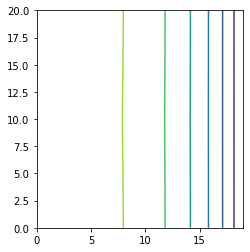

In [23]:
#heads at the end of the model; change plt.contour() to get heads at different level
plt.subplot(1,1,1, aspect='equal')
hds = bf.HeadFile(model_ws + modelname + '.hds')
head = hds.get_data()
plt.contour(head[0,:,:])
plt.savefig(model_ws+'Ex02_E2.png')
# plt.colorbar()